In [13]:
import os
import json
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
data_dir = '/opt/ml/detection/dataset'
anno_source = '/opt/ml/detection/dataset/train.json'

custom_json_dir = '/opt/ml/detection/cowork/teambase/custom_annos'
extension = '.json'
train_file_name = 'custom_train'
valid_file_name = 'custom_valid'

n_samples = 500
by_image = False # True

In [29]:
def plot_query(query):
    print(query["category_name"].value_counts())
    sns.set(font_scale=1.)
    query["category_name"].value_counts().sort_index().plot(kind='bar', figsize=(12, 6), rot=0)
    plt.xlabel("category", labelpad=10)
    plt.ylabel("frequency", labelpad=10)
    plt.title("Distribution of categories", y=1.02)


def mk_json(query, df_image, df_anno, source_info, source_licenses, source_categories, by_image):
    select_imgs, select_annos = query['image_id'].unique(), query['id'].unique()
    custom_images = df_image[df_image['id'].isin(select_imgs)].to_dict('records')
    if by_image:
        custom_annos = df_anno[df_anno['image_id'].isin(select_imgs)].to_dict('records')
    else:
        custom_annos = df_anno[df_anno['id'].isin(select_annos)].to_dict('records')

    output_info = source_info
    output_licenses = source_licenses
    output_categories = source_categories

    output_images = custom_images
    output_annotations = custom_annos

    custom_json = {
                'info' : output_info, 
                'licenses' : output_licenses, 
                'images' : output_images, 
                'categories' : output_categories, 
                'annotations' : output_annotations
                }

    print(f'selected [{len(custom_json["images"])}] images with [{len(custom_json["annotations"])}] annotations')
    return custom_json


def save_json(json_dir, file_name, json_data, extension='.json'):
    out_path = os.path.join(json_dir, file_name+extension)
    with open(out_path, 'w') as outfile:
        json.dump(json_data, outfile, indent=2)
    print(f"{file_name} save done!!")


def check_count(train_json, valid_json, query):
    assert len(train_json["images"])+len(valid_json["images"]) == len(query.groupby('image_id').size())
    print(len(train_json["images"])+len(valid_json["images"]))
    return True


In [16]:
with open(anno_source) as json_file:
    source_anns = json.load(json_file)

print(source_anns.keys())
source_info = source_anns['info']
source_licenses = source_anns['licenses']
source_images = source_anns['images']
source_categories = source_anns['categories']
source_annotations = source_anns['annotations']

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


In [17]:
df_images_origin = pd.json_normalize(source_images)
df_images_origin.head()

,width,height,file_name,license,flickr_url,coco_url,date_captured,id
0,1024,1024,train/0000.jpg,0,None,None,2020-12-26 14:44:23,0
1,1024,1024,train/0001.jpg,0,None,None,2021-01-10 16:30:39,1
2,1024,1024,train/0002.jpg,0,None,None,2020-12-27 17:55:52,2
3,1024,1024,train/0003.jpg,0,None,None,2021-03-31 12:10:36,3
4,1024,1024,train/0004.jpg,0,None,None,2021-01-01 18:52:38,4


In [18]:
df_anno_origin = pd.json_normalize(source_annotations)
df_anno_origin.head()

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4


In [19]:
label_name = [ann_dict['name'] for ann_dict in source_anns['categories']]

df_anno = df_anno_origin.copy()
df_anno['category_name'] = df_anno['category_id'].apply(lambda x: label_name[x])
df_anno[["X","Y","W","H"]] = df_anno['bbox'].tolist()
df_anno.drop(columns='bbox', inplace=True)
df_anno.head()

,image_id,category_id,area,iscrowd,id,category_name,X,Y,W,H
0,0,0,257301.66,0,0,General trash,197.6,193.7,547.8,469.7
1,1,3,10402.56,0,1,Metal,0.0,407.4,57.6,180.6
2,1,7,26259.36,0,2,Plastic bag,0.0,455.6,144.6,181.6
3,1,4,69096.17,0,3,Glass,722.3,313.4,274.3,251.9
4,1,5,24164.58,0,4,Plastic,353.2,671.0,233.7,103.4


In [20]:
query = df_anno[df_anno['area'] > 1000]
print(len(query))
query.head()
# query의 최종 출력엔 원하는 image_id와, id만 있어도 무방합니다.

22847


,image_id,category_id,area,iscrowd,id,category_name,X,Y,W,H
0,0,0,257301.66,0,0,General trash,197.6,193.7,547.8,469.7
1,1,3,10402.56,0,1,Metal,0.0,407.4,57.6,180.6
2,1,7,26259.36,0,2,Plastic bag,0.0,455.6,144.6,181.6
3,1,4,69096.17,0,3,Glass,722.3,313.4,274.3,251.9
4,1,5,24164.58,0,4,Plastic,353.2,671.0,233.7,103.4


In [21]:
valid_idx = random.sample(range(len(df_images_origin)), n_samples)
valid_query = query[query['image_id'].isin(valid_idx)]
train_query = query.drop(valid_query.index)

4883

Paper            5674
Plastic bag      4583
General trash    3501
Plastic          2584
Styrofoam        1128
Glass             894
Metal             833
Paper pack        777
Clothing          402
Battery           145
Name: category_name, dtype: int64


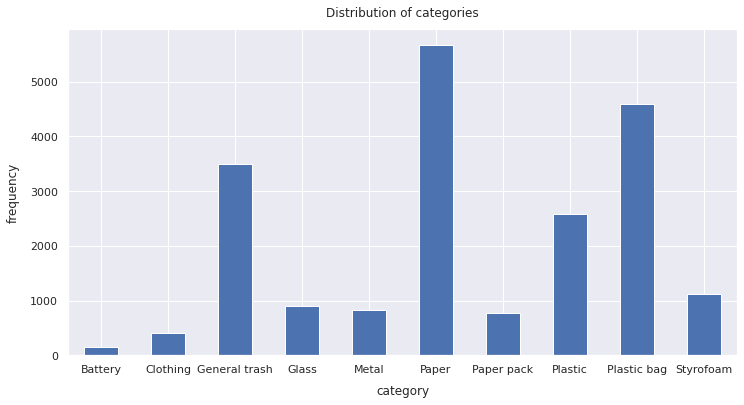

In [23]:
plot_query(train_query)

Paper            586
Plastic bag      562
General trash    368
Plastic          320
Styrofoam        129
Paper pack       114
Metal             87
Glass             82
Clothing          64
Battery           14
Name: category_name, dtype: int64


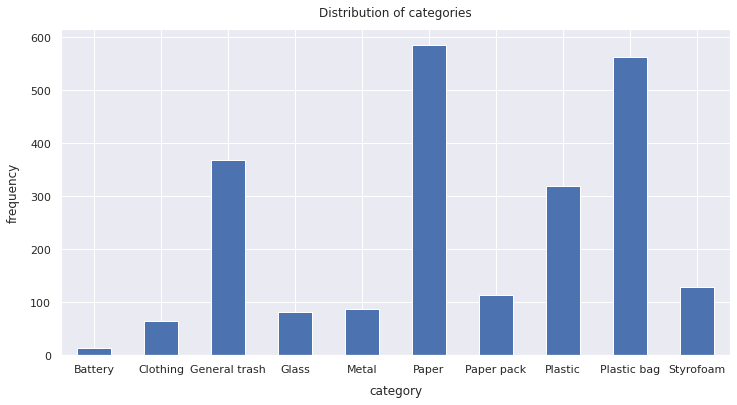

In [24]:
plot_query(valid_query)

In [25]:
train_json = mk_json(train_query, df_images_origin, df_anno_origin, source_info, source_licenses, source_categories, by_image=False)
valid_json = mk_json(valid_query, df_images_origin, df_anno_origin, source_info, source_licenses, source_categories, by_image=False)

selected [4383] images with [20521] annotations
selected [500] images with [2326] annotations


In [30]:
if check_count(train_json, valid_json, query):
    save_json(custom_json_dir, train_file_name, train_json)
    save_json(custom_json_dir, valid_file_name, valid_json)

4883
custom_train save done!!
custom_valid save done!!
